## Import Library yang Diperlukan

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import col
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## Memuat dan Membersihkan Data

Memuat data

In [ ]:
# Memuat data
df = pd.read_csv("The Seattle Police Department (SPD) Crime Data.csv")

# Menampilkan 5 baris pertama data awal
print(df.head())

  Report Number   Offense ID  Offense Start DateTime    Offense End DateTime  \
0   2020-044620  12605873663  02/05/2020 10:10:00 AM                     NaN   
1   2020-044452  12605598696  02/03/2020 08:00:00 AM  02/04/2020 08:00:00 AM   
2   2020-044465  12605567653  02/02/2020 08:30:00 PM  02/02/2020 09:30:00 PM   
3   2020-044225  12605174036  02/05/2020 01:17:00 AM  02/05/2020 02:21:00 AM   
4   2020-044076  12605081469  02/05/2020 12:51:21 AM                     NaN   

          Report DateTime Group A B Crime Against Category  \
0  02/05/2020 11:24:31 AM         A                SOCIETY   
1  02/05/2020 10:06:28 AM         A               PROPERTY   
2  02/05/2020 09:39:33 AM         A               PROPERTY   
3  02/05/2020 03:30:55 AM         A               PROPERTY   
4  02/05/2020 12:51:31 AM         B                SOCIETY   

                       Offense Parent Group  \
0                    DRUG/NARCOTIC OFFENSES   
1                             LARCENY-THEFT   
2    

In [ ]:
# Menampilkan jumlah baris dan kolom dalam DataFrame
print("Jumlah Baris:", len(df))
print("Jumlah Kolom:", len(df.columns))

# Mengidentifikasi dan menangani nilai yang hilang

# Data Sebelum Menangani Nilai yang Hilang
print("\n Data Sebelum Menangani Nilai yang Hilang:")
print(df.isna().sum())

# Menghapus baris dengan nilai yang hilang pada kolom tertentu
df_cleaned = df.dropna(subset=['Offense End DateTime', 'Offense Start DateTime', 'Precinct', 'Sector', 'Beat', '100 Block Address'])

# Data Setelah Menangani Nilai yang Hilang
print("\n Data Setelah Menangani Nilai yang Hilang:")
print(df_cleaned.isna().sum())

# Transformasi dan normalisasi data
scaler = StandardScaler()
df[['Longitude', 'Latitude']] = scaler.fit_transform(df[['Longitude', 'Latitude']])

# Pemfilteran dan menghapus duplikat
df = df.drop_duplicates(subset='Report Number')

# Standarisasi data kategorikal
df = pd.get_dummies(df, columns=['Group A B', 'Crime Against Category', 'Offense Parent Group'])

Jumlah Baris: 979713
Jumlah Kolom: 17

 Data Sebelum Menangani Nilai yang Hilang:
Report Number                  0
Offense ID                     0
Offense Start DateTime      1005
Offense End DateTime      436307
Report DateTime                0
Group A B                      0
Crime Against Category         0
Offense Parent Group           0
Offense                        0
Offense Code                   0
Precinct                       4
Sector                         2
Beat                           2
MCPP                           0
100 Block Address          39611
Longitude                      0
Latitude                       0
dtype: int64

 Data Setelah Menangani Nilai yang Hilang:
Report Number             0
Offense ID                0
Offense Start DateTime    0
Offense End DateTime      0
Report DateTime           0
Group A B                 0
Crime Against Category    0
Offense Parent Group      0
Offense                   0
Offense Code              0
Precinct            

## Visualisasi Data

 Distribusi dan Perbandingan Data

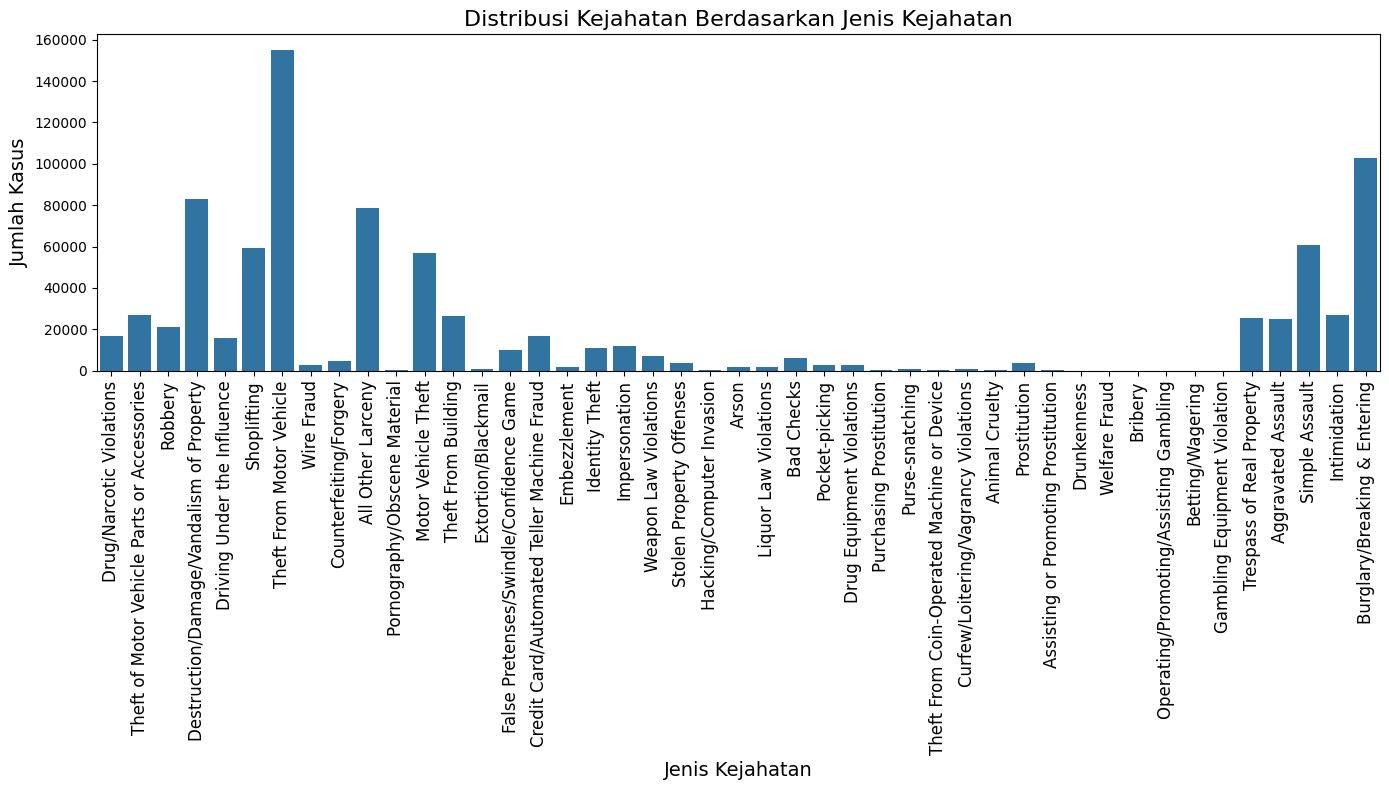

In [ ]:
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='Offense')
plt.title('Distribusi Kejahatan Berdasarkan Jenis Kejahatan', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Jenis Kejahatan', fontsize=14)
plt.ylabel('Jumlah Kasus', fontsize=14)
plt.tight_layout()
plt.show()

Visualisasi Deret Waktu

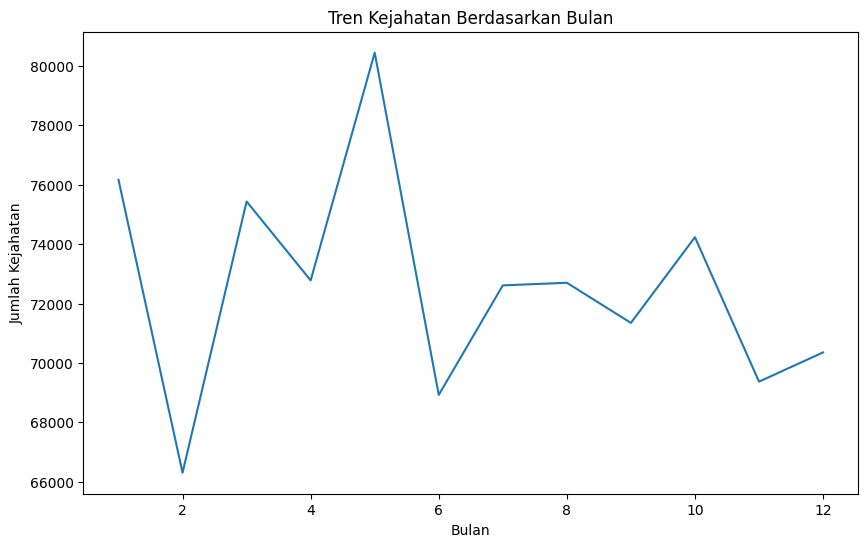

In [ ]:
df['Offense Start DateTime'] = pd.to_datetime(df['Offense Start DateTime'], errors='coerce')
df['Bulan'] = df['Offense Start DateTime'].dt.month
kejahatan_bulanan = df.groupby('Bulan').size()

plt.figure(figsize=(10, 6))
kejahatan_bulanan.plot(kind='line')
plt.title('Tren Kejahatan Berdasarkan Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Kejahatan')
plt.show()

Visualisasi Hubungan Antar Variabel

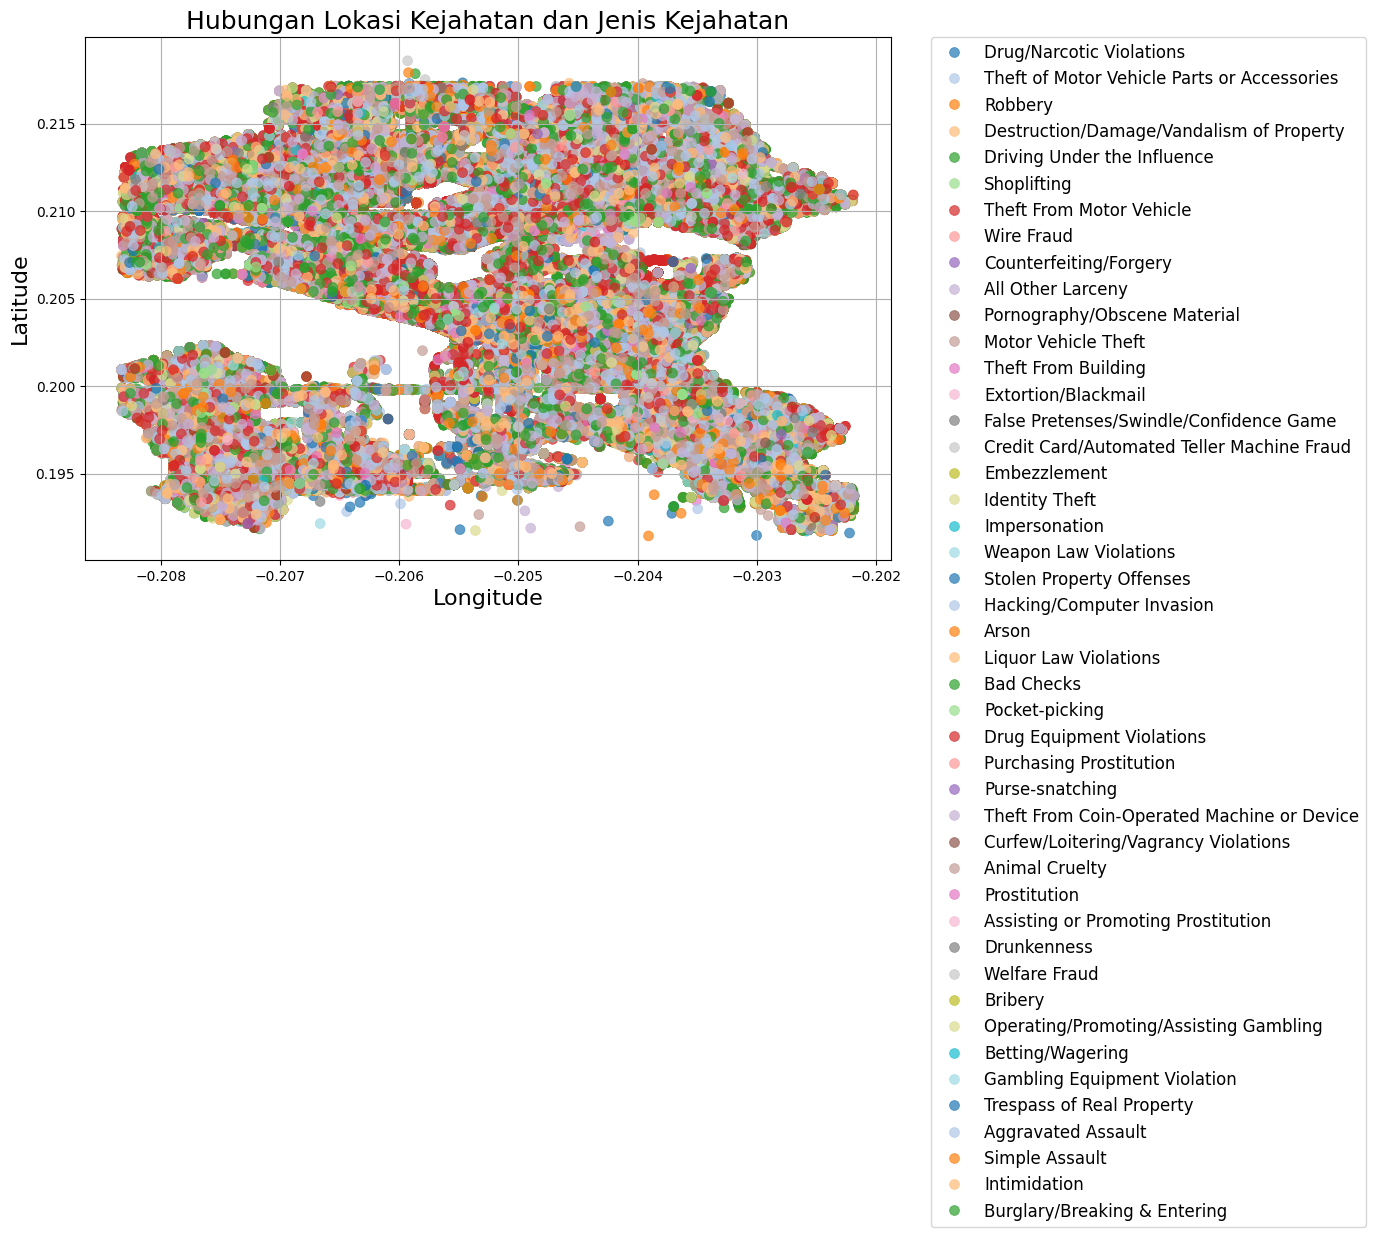

In [ ]:
plt.figure(figsize=(14, 10))
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Offense', palette='tab20', s=50, alpha=0.7, edgecolor=None)
plt.title('Hubungan Lokasi Kejahatan dan Jenis Kejahatan', fontsize=18)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## Machine Learning dengan Spark MLlib

Menyiapkan Data untuk Machine Learning

In [ ]:
# memulai proses konfigurasi SparkSession
spark = SparkSession.builder.appName("KlasifikasiDataKejahatan").getOrCreate()

# Mengonversi DataFrame Pandas ke DataFrame Spark
spark_df = spark.createDataFrame(df)

Membangun dan Mengevaluasi Model Klasifikasi serta visualisasi

+----------------------+-----+
|Crime Against Category|label|
+----------------------+-----+
|               SOCIETY|  2.0|
|              PROPERTY|  0.0|
|              PROPERTY|  0.0|
|              PROPERTY|  0.0|
|               SOCIETY|  2.0|
+----------------------+-----+
only showing top 5 rows

+----------------------------+
|features                    |
+----------------------------+
|[-122.385973723,47.64938723]|
|[-122.323399063,47.67511789]|
|[-122.29955218,47.66638407] |
|[-122.384864805,47.64292734]|
|[-122.366195342,47.66219308]|
+----------------------------+
only showing top 5 rows

Jumlah data latih: 784136
Jumlah data uji: 195577
Model berhasil dilatih.
Feature Importance:
     Feature  Importance
0  Longitude     0.67116
1   Latitude     0.32884


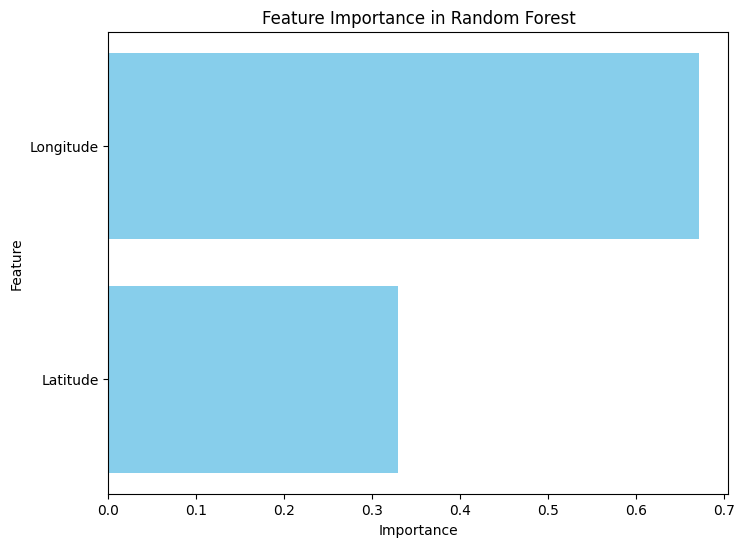

Akurasi Model: 0.75


In [ ]:
# memulai proses konfigurasi SparkSession
spark = SparkSession.builder.appName("KlasifikasiDataKejahatan").getOrCreate()

# Mengonversi DataFrame Pandas ke DataFrame Spark
spark_df = spark.createDataFrame(df)

# Mengonversi kolom Boolean menjadi String jika diperlukan
# Cek tipe data terlebih dahulu untuk memastikan hanya kolom yang perlu diubah
spark_df = spark_df.withColumn('Crime Against Category',
                               col('Crime Against Category').cast('string'))
==
# Preprocessing data dengan StringIndexer untuk kolom label
indexer = StringIndexer(inputCol='Crime Against Category', outputCol='label')
spark_df = indexer.fit(spark_df).transform(spark_df)

# Verifikasi data setelah indexing
spark_df.select("Crime Against Category", "label").show(5)

# Membuat vektor fitur dari kolom Longitude dan Latitude
feature_columns = ['Longitude', 'Latitude']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
spark_df = assembler.transform(spark_df)

# Verifikasi kolom features
spark_df.select("features").show(5, truncate=False)

# Membagi dataset menjadi data latih dan data uji
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=1234)

# Verifikasi jumlah data setelah pembagian
print(f"Jumlah data latih: {train_data.count()}")
print(f"Jumlah data uji: {test_data.count()}")

# Membuat model Random Forest
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=20)

# Melatih model
try:
    rf_model = rf.fit(train_data)
    print("Model berhasil dilatih.")
except Exception as e:
    print(f"Error saat melatih model: {e}")

# Mengambil feature importances dari model
importances = rf_model.featureImportances.toArray()

# Membuat DataFrame Pandas untuk visualisasi
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Menampilkan fitur paling berpengaruh
print("Feature Importance:")
print(importance_df)

# Visualisasi fitur paling berpengaruh
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Melakukan prediksi pada data uji
predictions = rf_model.transform(test_data)

# Menghitung akurasi model
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

# Menampilkan akurasi model
print(f"Akurasi Model: {accuracy:.2f}")
